# Tutorial Part 12: Predicting Ki of Ligands to a Protein


In this notebook, we analyze the BACE enyzme and build machine learning models for predicting the Ki of ligands to the protein. We will use the `deepchem` library to load this data into memory, split into train/test/validation folds, build and cross-validate models, and report statistics.

## Colab

This tutorial and the rest in this sequence are designed to be done in Google colab. If you'd like to open this notebook in colab, you can use the following link.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/deepchem/deepchem/blob/master/examples/tutorials/12_Predicting_Ki_of_Ligands_to_a_Protein.ipynb)

## Setup

To run DeepChem within Colab, you'll need to run the following cell of installation commands. This will take about 5 minutes to run to completion and install your environment.

In [1]:
!curl -Lo conda_installer.py https://raw.githubusercontent.com/deepchem/deepchem/master/scripts/colab_install.py
import conda_installer
conda_installer.install()
!/root/miniconda/bin/conda info -e

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3490  100  3490    0     0  20650      0 --:--:-- --:--:-- --:--:-- 20650


add /root/miniconda/lib/python3.6/site-packages to PYTHONPATH
python version: 3.6.9
fetching installer from https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
done
installing miniconda to /root/miniconda
done
installing rdkit, openmm, pdbfixer
added omnia to channels
added conda-forge to channels
done
conda packages installation finished!


# conda environments:
#
base                  *  /root/miniconda



In [2]:
!pip install --pre deepchem
import deepchem
deepchem.__version__

     |████████████████████████████████| 399kB 3.1MB/s 
  Created wheel for deepchem: filename=deepchem-2.4.0rc1.dev20200913134617-cp36-none-any.whl size=493496 sha256=675122bd2c835bfcf79ab9d50c96649b6121264f45bc5085fb76fe91e73060ae
  Stored in directory: /root/.cache/pip/wheels/e2/55/6f/55049318295d68e76bd0ab36d5e241a78935bc6438e5be51dd
Successfully built deepchem


'2.4.0-rc1.dev'

In [3]:
import os
import sys
import deepchem as dc
from deepchem.utils.save import load_from_disk

current_dir = os.path.dirname(os.path.realpath("__file__"))
dc.utils.download_url("https://s3-us-west-1.amazonaws.com/deepchem.io/datasets/desc_canvas_aug30.csv",
                      current_dir)
dataset_file = "desc_canvas_aug30.csv"
dataset = load_from_disk(dataset_file)
num_display=10
pretty_columns = (
    "[" + ",".join(["'%s'" % column for column in dataset.columns.values[:num_display]])
    + ",...]")

dc.utils.download_url("https://s3-us-west-1.amazonaws.com/deepchem.io/datasets/crystal_desc_canvas_aug30.csv",
                      current_dir)
crystal_dataset_file = "crystal_desc_canvas_aug30.csv"
crystal_dataset = load_from_disk(crystal_dataset_file)

print("Columns of dataset: %s" % pretty_columns)
print("Number of examples in dataset: %s" % str(dataset.shape[0]))
print("Number of examples in crystal dataset: %s" % str(crystal_dataset.shape[0]))

deepchem.utils.save has been deprecated.
The utilities in save.py are moved to deepchem.utils.data_utils or deepchem.utils.genomics_utils.


Columns of dataset: ['mol','CID','Class','Model','pIC50','MW','AlogP','HBA','HBD','RB',...]
Number of examples in dataset: 1522
Number of examples in crystal dataset: 25


To gain a visual understanding of compounds in our dataset, let's draw them using rdkit. We define a couple of helper functions to get started.

In [4]:
import tempfile
from rdkit import Chem
from rdkit.Chem import Draw
from itertools import islice
from IPython.display import Image, display, HTML

def display_images(filenames):
    """Helper to pretty-print images."""
    for filename in filenames:
        display(Image(filename))

def mols_to_pngs(mols, basename="test"):
    """Helper to write RDKit mols to png files."""
    filenames = []
    for i, mol in enumerate(mols):
        filename = "BACE_%s%d.png" % (basename, i)
        Draw.MolToFile(mol, filename)
        filenames.append(filename)
    return filenames

Now, we display a compound from the dataset. Note the complex ring structures and polar structures.

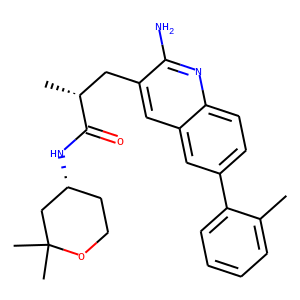

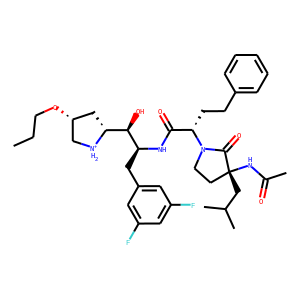

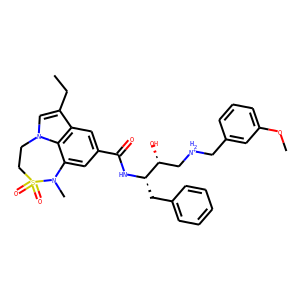

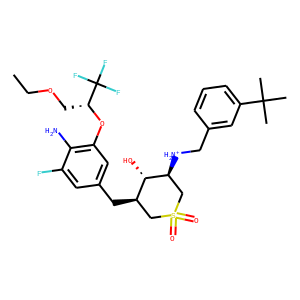

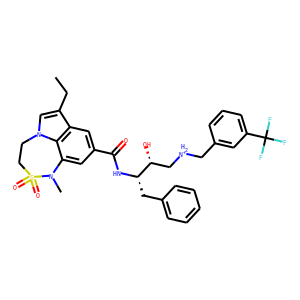

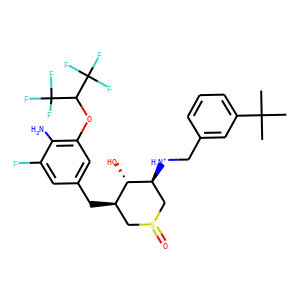

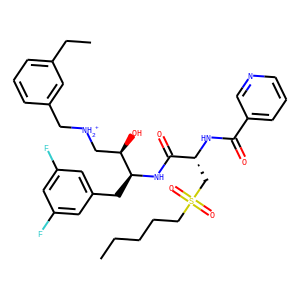

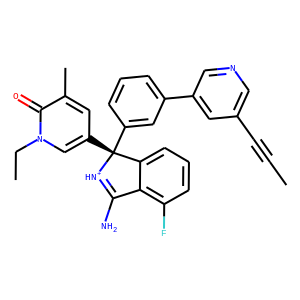

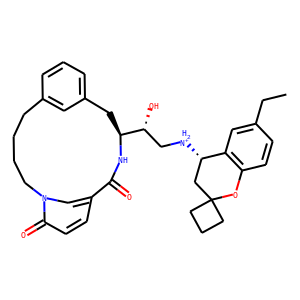

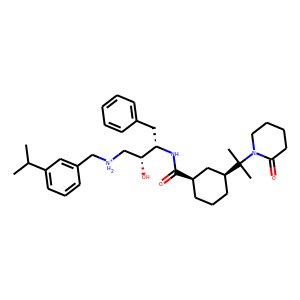

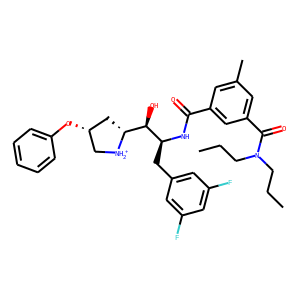

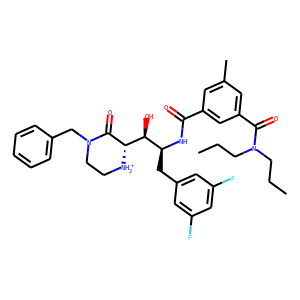

In [5]:
num_to_display = 12
molecules = []
for _, data in islice(dataset.iterrows(), num_to_display):
    molecules.append(Chem.MolFromSmiles(data["mol"]))
display_images(mols_to_pngs(molecules, basename="dataset"))

Now let's picture the compounds in the crystal structure collection

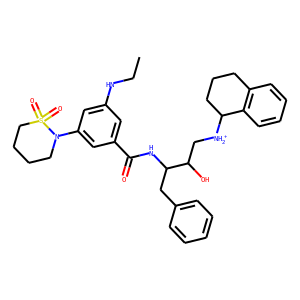

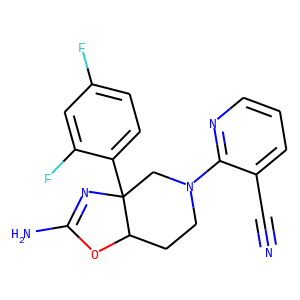

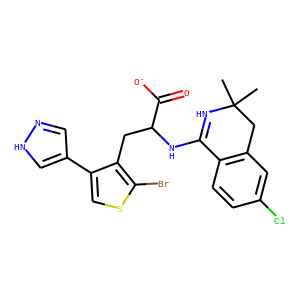

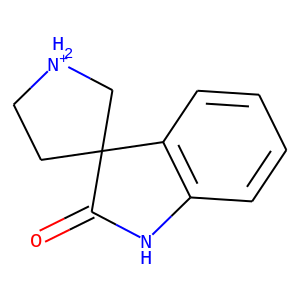

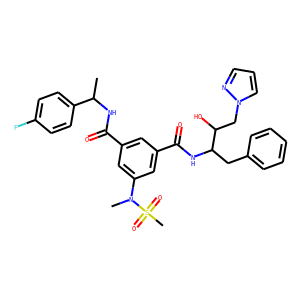

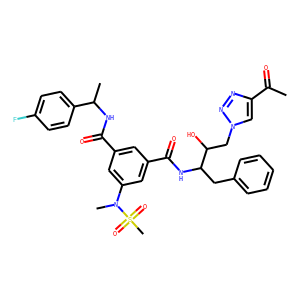

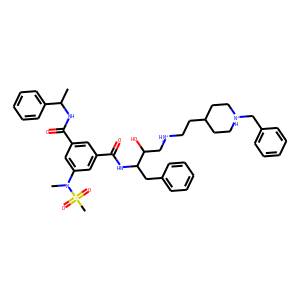

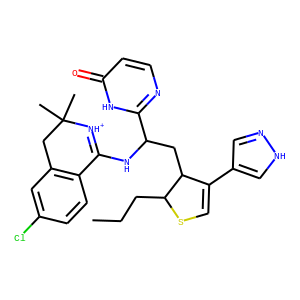

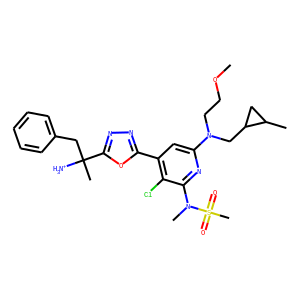

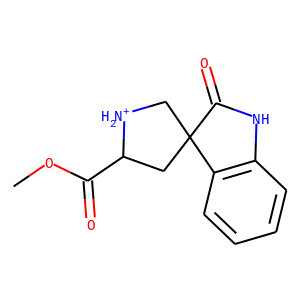

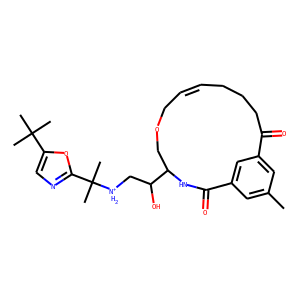

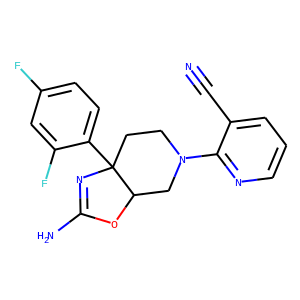

In [6]:
num_to_display = 12
molecules = []
for _, data in islice(crystal_dataset.iterrows(), num_to_display):
    molecules.append(Chem.MolFromSmiles(data["mol"]))
display_images(mols_to_pngs(molecules, basename="crystal_dataset"))

Analyzing the distribution of pIC50 values in the dataset gives us a nice spread.

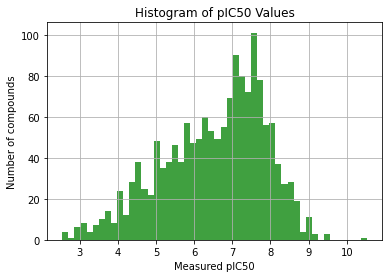

In [7]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

pIC50s = np.array(dataset["pIC50"])
# Remove some dirty data from the dataset
pIC50s = [pIC50 for pIC50 in pIC50s if pIC50 != '']
n, bins, patches = plt.hist(pIC50s, 50, facecolor='green', alpha=0.75)
plt.xlabel('Measured pIC50')
plt.ylabel('Number of compounds')
plt.title(r'Histogram of pIC50 Values')
plt.grid(True)
plt.show()

We now featurize the data using the Canvas samples. To do so, we must specify the columns in the data input that correspond to the features. (Note that CanvasUID is excluded!)

In [8]:
user_specified_features = ['MW','AlogP','HBA','HBD','RB','HeavyAtomCount','ChiralCenterCount','ChiralCenterCountAllPossible','RingCount','PSA','Estate','MR','Polar','sLi_Key','ssBe_Key','ssssBem_Key','sBH2_Key','ssBH_Key','sssB_Key','ssssBm_Key','sCH3_Key','dCH2_Key','ssCH2_Key','tCH_Key','dsCH_Key','aaCH_Key','sssCH_Key','ddC_Key','tsC_Key','dssC_Key','aasC_Key','aaaC_Key','ssssC_Key','sNH3_Key','sNH2_Key','ssNH2_Key','dNH_Key','ssNH_Key','aaNH_Key','tN_Key','sssNH_Key','dsN_Key','aaN_Key','sssN_Key','ddsN_Key','aasN_Key','ssssN_Key','daaN_Key','sOH_Key','dO_Key','ssO_Key','aaO_Key','aOm_Key','sOm_Key','sF_Key','sSiH3_Key','ssSiH2_Key','sssSiH_Key','ssssSi_Key','sPH2_Key','ssPH_Key','sssP_Key','dsssP_Key','ddsP_Key','sssssP_Key','sSH_Key','dS_Key','ssS_Key','aaS_Key','dssS_Key','ddssS_Key','ssssssS_Key','Sm_Key','sCl_Key','sGeH3_Key','ssGeH2_Key','sssGeH_Key','ssssGe_Key','sAsH2_Key','ssAsH_Key','sssAs_Key','dsssAs_Key','ddsAs_Key','sssssAs_Key','sSeH_Key','dSe_Key','ssSe_Key','aaSe_Key','dssSe_Key','ssssssSe_Key','ddssSe_Key','sBr_Key','sSnH3_Key','ssSnH2_Key','sssSnH_Key','ssssSn_Key','sI_Key','sPbH3_Key','ssPbH2_Key','sssPbH_Key','ssssPb_Key','sLi_Cnt','ssBe_Cnt','ssssBem_Cnt','sBH2_Cnt','ssBH_Cnt','sssB_Cnt','ssssBm_Cnt','sCH3_Cnt','dCH2_Cnt','ssCH2_Cnt','tCH_Cnt','dsCH_Cnt','aaCH_Cnt','sssCH_Cnt','ddC_Cnt','tsC_Cnt','dssC_Cnt','aasC_Cnt','aaaC_Cnt','ssssC_Cnt','sNH3_Cnt','sNH2_Cnt','ssNH2_Cnt','dNH_Cnt','ssNH_Cnt','aaNH_Cnt','tN_Cnt','sssNH_Cnt','dsN_Cnt','aaN_Cnt','sssN_Cnt','ddsN_Cnt','aasN_Cnt','ssssN_Cnt','daaN_Cnt','sOH_Cnt','dO_Cnt','ssO_Cnt','aaO_Cnt','aOm_Cnt','sOm_Cnt','sF_Cnt','sSiH3_Cnt','ssSiH2_Cnt','sssSiH_Cnt','ssssSi_Cnt','sPH2_Cnt','ssPH_Cnt','sssP_Cnt','dsssP_Cnt','ddsP_Cnt','sssssP_Cnt','sSH_Cnt','dS_Cnt','ssS_Cnt','aaS_Cnt','dssS_Cnt','ddssS_Cnt','ssssssS_Cnt','Sm_Cnt','sCl_Cnt','sGeH3_Cnt','ssGeH2_Cnt','sssGeH_Cnt','ssssGe_Cnt','sAsH2_Cnt','ssAsH_Cnt','sssAs_Cnt','dsssAs_Cnt','ddsAs_Cnt','sssssAs_Cnt','sSeH_Cnt','dSe_Cnt','ssSe_Cnt','aaSe_Cnt','dssSe_Cnt','ssssssSe_Cnt','ddssSe_Cnt','sBr_Cnt','sSnH3_Cnt','ssSnH2_Cnt','sssSnH_Cnt','ssssSn_Cnt','sI_Cnt','sPbH3_Cnt','ssPbH2_Cnt','sssPbH_Cnt','ssssPb_Cnt','sLi_Sum','ssBe_Sum','ssssBem_Sum','sBH2_Sum','ssBH_Sum','sssB_Sum','ssssBm_Sum','sCH3_Sum','dCH2_Sum','ssCH2_Sum','tCH_Sum','dsCH_Sum','aaCH_Sum','sssCH_Sum','ddC_Sum','tsC_Sum','dssC_Sum','aasC_Sum','aaaC_Sum','ssssC_Sum','sNH3_Sum','sNH2_Sum','ssNH2_Sum','dNH_Sum','ssNH_Sum','aaNH_Sum','tN_Sum','sssNH_Sum','dsN_Sum','aaN_Sum','sssN_Sum','ddsN_Sum','aasN_Sum','ssssN_Sum','daaN_Sum','sOH_Sum','dO_Sum','ssO_Sum','aaO_Sum','aOm_Sum','sOm_Sum','sF_Sum','sSiH3_Sum','ssSiH2_Sum','sssSiH_Sum','ssssSi_Sum','sPH2_Sum','ssPH_Sum','sssP_Sum','dsssP_Sum','ddsP_Sum','sssssP_Sum','sSH_Sum','dS_Sum','ssS_Sum','aaS_Sum','dssS_Sum','ddssS_Sum','ssssssS_Sum','Sm_Sum','sCl_Sum','sGeH3_Sum','ssGeH2_Sum','sssGeH_Sum','ssssGe_Sum','sAsH2_Sum','ssAsH_Sum','sssAs_Sum','dsssAs_Sum','ddsAs_Sum','sssssAs_Sum','sSeH_Sum','dSe_Sum','ssSe_Sum','aaSe_Sum','dssSe_Sum','ssssssSe_Sum','ddssSe_Sum','sBr_Sum','sSnH3_Sum','ssSnH2_Sum','sssSnH_Sum','ssssSn_Sum','sI_Sum','sPbH3_Sum','ssPbH2_Sum','sssPbH_Sum','ssssPb_Sum','sLi_Avg','ssBe_Avg','ssssBem_Avg','sBH2_Avg','ssBH_Avg','sssB_Avg','ssssBm_Avg','sCH3_Avg','dCH2_Avg','ssCH2_Avg','tCH_Avg','dsCH_Avg','aaCH_Avg','sssCH_Avg','ddC_Avg','tsC_Avg','dssC_Avg','aasC_Avg','aaaC_Avg','ssssC_Avg','sNH3_Avg','sNH2_Avg','ssNH2_Avg','dNH_Avg','ssNH_Avg','aaNH_Avg','tN_Avg','sssNH_Avg','dsN_Avg','aaN_Avg','sssN_Avg','ddsN_Avg','aasN_Avg','ssssN_Avg','daaN_Avg','sOH_Avg','dO_Avg','ssO_Avg','aaO_Avg','aOm_Avg','sOm_Avg','sF_Avg','sSiH3_Avg','ssSiH2_Avg','sssSiH_Avg','ssssSi_Avg','sPH2_Avg','ssPH_Avg','sssP_Avg','dsssP_Avg','ddsP_Avg','sssssP_Avg','sSH_Avg','dS_Avg','ssS_Avg','aaS_Avg','dssS_Avg','ddssS_Avg','ssssssS_Avg','Sm_Avg','sCl_Avg','sGeH3_Avg','ssGeH2_Avg','sssGeH_Avg','ssssGe_Avg','sAsH2_Avg','ssAsH_Avg','sssAs_Avg','dsssAs_Avg','ddsAs_Avg','sssssAs_Avg','sSeH_Avg','dSe_Avg','ssSe_Avg','aaSe_Avg','dssSe_Avg','ssssssSe_Avg','ddssSe_Avg','sBr_Avg','sSnH3_Avg','ssSnH2_Avg','sssSnH_Avg','ssssSn_Avg','sI_Avg','sPbH3_Avg','ssPbH2_Avg','sssPbH_Avg','ssssPb_Avg','First Zagreb (ZM1)','First Zagreb index by valence vertex degrees (ZM1V)','Second Zagreb (ZM2)','Second Zagreb index by valence vertex degrees (ZM2V)','Polarity (Pol)','Narumi Simple Topological (NST)','Narumi Harmonic Topological (NHT)','Narumi Geometric Topological (NGT)','Total structure connectivity (TSC)','Wiener (W)','Mean Wiener (MW)','Xu (Xu)','Quadratic (QIndex)','Radial centric (RC)','Mean Square Distance Balaban (MSDB)','Superpendentic (SP)','Harary (Har)','Log of product of row sums (LPRS)','Pogliani (Pog)','Schultz Molecular Topological (SMT)','Schultz Molecular Topological by valence vertex degrees (SMTV)','Mean Distance Degree Deviation (MDDD)','Ramification (Ram)','Gutman Molecular Topological (GMT)','Gutman MTI by valence vertex degrees (GMTV)','Average vertex distance degree (AVDD)','Unipolarity (UP)','Centralization (CENT)','Variation (VAR)','Molecular electrotopological variation (MEV)','Maximal electrotopological positive variation (MEPV)','Maximal electrotopological negative variation (MENV)','Eccentric connectivity (ECCc)','Eccentricity (ECC)','Average eccentricity (AECC)','Eccentric (DECC)','Valence connectivity index chi-0 (vX0)','Valence connectivity index chi-1 (vX1)','Valence connectivity index chi-2 (vX2)','Valence connectivity index chi-3 (vX3)','Valence connectivity index chi-4 (vX4)','Valence connectivity index chi-5 (vX5)','Average valence connectivity index chi-0 (AvX0)','Average valence connectivity index chi-1 (AvX1)','Average valence connectivity index chi-2 (AvX2)','Average valence connectivity index chi-3 (AvX3)','Average valence connectivity index chi-4 (AvX4)','Average valence connectivity index chi-5 (AvX5)','Quasi Wiener (QW)','First Mohar (FM)','Second Mohar (SM)','Spanning tree number (STN)','Kier benzene-likeliness index (KBLI)','Topological charge index of order 1 (TCI1)','Topological charge index of order 2 (TCI2)','Topological charge index of order 3 (TCI3)','Topological charge index of order 4 (TCI4)','Topological charge index of order 5 (TCI5)','Topological charge index of order 6 (TCI6)','Topological charge index of order 7 (TCI7)','Topological charge index of order 8 (TCI8)','Topological charge index of order 9 (TCI9)','Topological charge index of order 10 (TCI10)','Mean topological charge index of order 1 (MTCI1)','Mean topological charge index of order 2 (MTCI2)','Mean topological charge index of order 3 (MTCI3)','Mean topological charge index of order 4 (MTCI4)','Mean topological charge index of order 5 (MTCI5)','Mean topological charge index of order 6 (MTCI6)','Mean topological charge index of order 7 (MTCI7)','Mean topological charge index of order 8 (MTCI8)','Mean topological charge index of order 9 (MTCI9)','Mean topological charge index of order 10 (MTCI10)','Global topological charge (GTC)','Hyper-distance-path index (HDPI)','Reciprocal hyper-distance-path index (RHDPI)','Square reciprocal distance sum (SRDS)','Modified Randic connectivity (MRC)','Balaban centric (BC)','Lopping centric (LC)','Kier Hall electronegativity (KHE)','Sum of topological distances between N..N (STD(N N))','Sum of topological distances between N..O (STD(N O))','Sum of topological distances between N..S (STD(N S))','Sum of topological distances between N..P (STD(N P))','Sum of topological distances between N..F (STD(N F))','Sum of topological distances between N..Cl (STD(N Cl))','Sum of topological distances between N..Br (STD(N Br))','Sum of topological distances between N..I (STD(N I))','Sum of topological distances between O..O (STD(O O))','Sum of topological distances between O..S (STD(O S))','Sum of topological distances between O..P (STD(O P))','Sum of topological distances between O..F (STD(O F))','Sum of topological distances between O..Cl (STD(O Cl))','Sum of topological distances between O..Br (STD(O Br))','Sum of topological distances between O..I (STD(O I))','Sum of topological distances between S..S (STD(S S))','Sum of topological distances between S..P (STD(S P))','Sum of topological distances between S..F (STD(S F))','Sum of topological distances between S..Cl (STD(S Cl))','Sum of topological distances between S..Br (STD(S Br))','Sum of topological distances between S..I (STD(S I))','Sum of topological distances between P..P (STD(P P))','Sum of topological distances between P..F (STD(P F))','Sum of topological distances between P..Cl (STD(P Cl))','Sum of topological distances between P..Br (STD(P Br))','Sum of topological distances between P..I (STD(P I))','Sum of topological distances between F..F (STD(F F))','Sum of topological distances between F..Cl (STD(F Cl))','Sum of topological distances between F..Br (STD(F Br))','Sum of topological distances between F..I (STD(F I))','Sum of topological distances between Cl..Cl (STD(Cl Cl))','Sum of topological distances between Cl..Br (STD(Cl Br))','Sum of topological distances between Cl..I (STD(Cl I))','Sum of topological distances between Br..Br (STD(Br Br))','Sum of topological distances between Br..I (STD(Br I))','Sum of topological distances between I..I (STD(I I))','Wiener-type index from Z weighted distance matrix - Barysz matrix (WhetZ)','Wiener-type index from electronegativity weighted distance matrix (Whete)','Wiener-type index from mass weighted distance matrix (Whetm)','Wiener-type index from van der waals weighted distance matrix (Whetv)','Wiener-type index from polarizability weighted distance matrix (Whetp)','Balaban-type index from Z weighted distance matrix - Barysz matrix (JhetZ)','Balaban-type index from electronegativity weighted distance matrix (Jhete)','Balaban-type index from mass weighted distance matrix (Jhetm)','Balaban-type index from van der waals weighted distance matrix (Jhetv)','Balaban-type index from polarizability weighted distance matrix (Jhetp)','Topological diameter (TD)','Topological radius (TR)','Petitjean 2D shape (PJ2DS)','Balaban distance connectivity index (J)','Solvation connectivity index chi-0 (SCIX0)','Solvation connectivity index chi-1 (SCIX1)','Solvation connectivity index chi-2 (SCIX2)','Solvation connectivity index chi-3 (SCIX3)','Solvation connectivity index chi-4 (SCIX4)','Solvation connectivity index chi-5 (SCIX5)','Connectivity index chi-0 (CIX0)','Connectivity chi-1 [Randic connectivity] (CIX1)','Connectivity index chi-2 (CIX2)','Connectivity index chi-3 (CIX3)','Connectivity index chi-4 (CIX4)','Connectivity index chi-5 (CIX5)','Average connectivity index chi-0 (ACIX0)','Average connectivity index chi-1 (ACIX1)','Average connectivity index chi-2 (ACIX2)','Average connectivity index chi-3 (ACIX3)','Average connectivity index chi-4 (ACIX4)','Average connectivity index chi-5 (ACIX5)','reciprocal distance Randic-type index (RDR)','reciprocal distance square Randic-type index (RDSR)','1-path Kier alpha-modified shape index (KAMS1)','2-path Kier alpha-modified shape index (KAMS2)','3-path Kier alpha-modified shape index (KAMS3)','Kier flexibility (KF)','path/walk 2 - Randic shape index (RSIpw2)','path/walk 3 - Randic shape index (RSIpw3)','path/walk 4 - Randic shape index (RSIpw4)','path/walk 5 - Randic shape index (RSIpw5)','E-state topological parameter (ETP)','Ring Count 3 (RNGCNT3)','Ring Count 4 (RNGCNT4)','Ring Count 5 (RNGCNT5)','Ring Count 6 (RNGCNT6)','Ring Count 7 (RNGCNT7)','Ring Count 8 (RNGCNT8)','Ring Count 9 (RNGCNT9)','Ring Count 10 (RNGCNT10)','Ring Count 11 (RNGCNT11)','Ring Count 12 (RNGCNT12)','Ring Count 13 (RNGCNT13)','Ring Count 14 (RNGCNT14)','Ring Count 15 (RNGCNT15)','Ring Count 16 (RNGCNT16)','Ring Count 17 (RNGCNT17)','Ring Count 18 (RNGCNT18)','Ring Count 19 (RNGCNT19)','Ring Count 20 (RNGCNT20)','Atom Count (ATMCNT)','Bond Count (BNDCNT)','Atoms in Ring System (ATMRNGCNT)','Bonds in Ring System (BNDRNGCNT)','Cyclomatic number (CYCLONUM)','Number of ring systems (NRS)','Normalized number of ring systems (NNRS)','Ring Fusion degree (RFD)','Ring perimeter (RNGPERM)','Ring bridge count (RNGBDGE)','Molecule cyclized degree (MCD)','Ring Fusion density (RFDELTA)','Ring complexity index (RCI)','Van der Waals surface area (VSA)','MR1 (MR1)','MR2 (MR2)','MR3 (MR3)','MR4 (MR4)','MR5 (MR5)','MR6 (MR6)','MR7 (MR7)','MR8 (MR8)','ALOGP1 (ALOGP1)','ALOGP2 (ALOGP2)','ALOGP3 (ALOGP3)','ALOGP4 (ALOGP4)','ALOGP5 (ALOGP5)','ALOGP6 (ALOGP6)','ALOGP7 (ALOGP7)','ALOGP8 (ALOGP8)','ALOGP9 (ALOGP9)','ALOGP10 (ALOGP10)','PEOE1 (PEOE1)','PEOE2 (PEOE2)','PEOE3 (PEOE3)','PEOE4 (PEOE4)','PEOE5 (PEOE5)','PEOE6 (PEOE6)','PEOE7 (PEOE7)','PEOE8 (PEOE8)','PEOE9 (PEOE9)','PEOE10 (PEOE10)','PEOE11 (PEOE11)','PEOE12 (PEOE12)','PEOE13 (PEOE13)','PEOE14 (PEOE14)']

In [9]:
import deepchem as dc
import tempfile, shutil

featurizer = dc.feat.UserDefinedFeaturizer(user_specified_features)
loader = dc.data.UserCSVLoader(
      tasks=["Class"], smiles_field="mol", id_field="mol",
      featurizer=featurizer)
dataset = loader.featurize(dataset_file)
crystal_dataset = loader.featurize(crystal_dataset_file)

smiles_field is deprecated and will be removed in a future version of DeepChem.Use feature_field instead.
/usr/local/lib/python3.6/dist-packages/deepchem/data/data_loader.py:162: FutureWarning: featurize() is deprecated and has been renamed to create_dataset().featurize() will be removed in DeepChem 3.0
  "featurize() will be removed in DeepChem 3.0", FutureWarning)


This data is already split into three subsets "Train" and "Test" with 20% and 80% respectively of the total data from the BACE enzyme. There is also a "Validation" set that contains data from a separate (but related assay). (Note that these names are really misnomers. The "Test" set would be called a validation set in standard machine-learning practice and the "Validation" set would typically be called an external test set.) Hence, we will rename the datasets after loading them.

In [10]:
# splitter = dc.splits.SpecifiedSplitter(dataset_file, "Model")
# train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(
#     dataset)
# #NOTE THE RENAMING:
# valid_dataset, test_dataset = test_dataset, valid_dataset

Let's quickly take a look at a compound in the validation set. (The compound displayed earlier was drawn from the train set).

In [11]:
# print(valid_dataset.ids)
# valid_mols = [Chem.MolFromSmiles(compound)
#               for compound in islice(valid_dataset.ids, num_to_display)]
# display_images(mols_to_pngs(valid_mols, basename="valid_set"))

Let's now write these datasets to disk

In [12]:
# print("Number of compounds in train set")
# print(len(train_dataset))
# print("Number of compounds in validation set")
# print(len(valid_dataset))
# print("Number of compounds in test set")
# print(len(test_dataset))
# print("Number of compounds in crystal set")
# print(len(crystal_dataset))

The performance of common machine-learning algorithms can be very sensitive to preprocessing of the data. One common transformation applied to data is to normalize it to have zero-mean and unit-standard-deviation. We will apply this transformation to the pIC50 values (as seen above, the pIC50s range from 2 to 11).

In [13]:
# transformers = [
#     dc.trans.NormalizationTransformer(transform_X=True, dataset=train_dataset),
#     dc.trans.ClippingTransformer(transform_X=True, dataset=train_dataset)]

# datasets = [train_dataset, valid_dataset, test_dataset, crystal_dataset]
# for i, dataset in enumerate(datasets):
#   for transformer in transformers:
#       datasets[i] = transformer.transform(dataset)
# train_dataset, valid_dataset, test_dataset, crystal_dataset = datasets

We now fit simple random forest models to our datasets.

In [14]:
# from sklearn.ensemble import RandomForestClassifier

# def rf_model_builder(model_params, model_dir):
#   sklearn_model = RandomForestClassifier(**model_params)
#   return dc.models.SklearnModel(sklearn_model, model_dir)
# params_dict = {
#     "n_estimators": [10, 100],
#     "max_features": ["auto", "sqrt", "log2", None],
# }

# metric = dc.metrics.Metric(dc.metrics.roc_auc_score)
# optimizer = dc.hyper.HyperparamOpt(rf_model_builder)
# best_rf, best_rf_hyperparams, all_rf_results = optimizer.hyperparam_search(
#     params_dict, train_dataset, valid_dataset, transformers,
#     metric=metric)

In [15]:
# import numpy.random

# params_dict = {"learning_rate": np.power(10., np.random.uniform(-5, -3, size=1)),
#                "weight_decay_penalty": np.power(10, np.random.uniform(-6, -4, size=1)),
#                "nb_epoch": [40] }
# n_features = train_dataset.get_data_shape()[0]
# def model_builder(model_params, model_dir):
#   model = dc.models.MultitaskClassifier(
#     1, n_features, layer_sizes=[1000], dropouts=.25,
#     batch_size=50, **model_params)
#   return model

# optimizer = dc.hyper.HyperparamOpt(model_builder)
# best_dnn, best_dnn_hyperparams, all_dnn_results = optimizer.hyperparam_search(
#     params_dict, train_dataset, valid_dataset, transformers,
#     metric=metric)

Now let's evaluate the best model on the validation and test sets and save the results to csv.

In [16]:
# from deepchem.utils.evaluate import Evaluator

# rf_train_csv_out = "rf_train_regressor.csv"
# rf_train_stats_out = "rf_train_stats_regressor.txt"
# rf_train_evaluator = Evaluator(best_rf, train_dataset, transformers)
# rf_train_score = rf_train_evaluator.compute_model_performance(
#     [metric], rf_train_csv_out, rf_train_stats_out)
# print("RF Train set AUC %f" % (rf_train_score["roc_auc_score"]))

# rf_valid_csv_out = "rf_valid_regressor.csv"
# rf_valid_stats_out = "rf_valid_stats_regressor.txt"
# rf_valid_evaluator = Evaluator(best_rf, valid_dataset, transformers)
# rf_valid_score = rf_valid_evaluator.compute_model_performance(
#     [metric], rf_valid_csv_out, rf_valid_stats_out)
# print("RF Valid set AUC %f" % (rf_valid_score["roc_auc_score"]))

# rf_test_csv_out = "rf_test_regressor.csv"
# rf_test_stats_out = "rf_test_stats_regressor.txt"
# rf_test_evaluator = Evaluator(best_rf, test_dataset, transformers)
# rf_test_score = rf_test_evaluator.compute_model_performance(
#     [metric], rf_test_csv_out, rf_test_stats_out)
# print("RF Test set AUC %f" % (rf_test_score["roc_auc_score"]))

# rf_crystal_csv_out = "rf_crystal_regressor.csv"
# rf_crystal_stats_out = "rf_crystal_stats_regressor.txt"
# rf_crystal_evaluator = Evaluator(best_rf, crystal_dataset, transformers)
# rf_crystal_score = rf_crystal_evaluator.compute_model_performance(
#     [metric], rf_crystal_csv_out, rf_crystal_stats_out)
# print("RF Crystal set R^2 %f" % (rf_crystal_score["roc_auc_score"]))

In [17]:
# dnn_train_csv_out = "dnn_train_classifier.csv"
# dnn_train_stats_out = "dnn_train_classifier_stats.txt"
# dnn_train_evaluator = Evaluator(best_dnn, train_dataset, transformers)
# dnn_train_score = dnn_train_evaluator.compute_model_performance(
#     [metric], dnn_train_csv_out, dnn_train_stats_out)
# print("DNN Train set AUC %f" % (dnn_train_score["roc_auc_score"]))

# dnn_valid_csv_out = "dnn_valid_classifier.csv"
# dnn_valid_stats_out = "dnn_valid_classifier_stats.txt"
# dnn_valid_evaluator = Evaluator(best_dnn, valid_dataset, transformers)
# dnn_valid_score = dnn_valid_evaluator.compute_model_performance(
#     [metric], dnn_valid_csv_out, dnn_valid_stats_out)
# print("DNN Valid set AUC %f" % (dnn_valid_score["roc_auc_score"]))

# dnn_test_csv_out = "dnn_test_classifier.csv"
# dnn_test_stats_out = "dnn_test_classifier_stats.txt"
# dnn_test_evaluator = Evaluator(best_dnn, test_dataset, transformers)
# dnn_test_score = dnn_test_evaluator.compute_model_performance(
#     [metric], dnn_test_csv_out, dnn_test_stats_out)
# print("DNN Test set AUC %f" % (dnn_test_score["roc_auc_score"]))

# dnn_crystal_csv_out = "dnn_crystal_classifier.csv"
# dnn_crystal_stats_out = "dnn_crystal_stats_classifier.txt"
# dnn_crystal_evaluator = Evaluator(best_dnn, crystal_dataset, transformers)
# dnn_crystal_score = dnn_crystal_evaluator.compute_model_performance(
#     [metric], dnn_crystal_csv_out, dnn_crystal_stats_out)
# print("DNN Crystal set AUC %f" % (dnn_crystal_score["roc_auc_score"]))

Now, we construct regression models for the data.

In [18]:
# #Make directories to store the raw and featurized datasets.
# featurizer = dc.feat.UserDefinedFeaturizer(user_specified_features)
# loader = dc.data.UserCSVLoader(
#     tasks=["pIC50"], smiles_field="mol", id_field="CID",
#     featurizer=featurizer)
# dataset = loader.featurize(dataset_file)
# crystal_dataset = loader.featurize(crystal_dataset_file)

In [19]:
# splitter = dc.splits.SpecifiedSplitter(dataset_file, "Model")
# train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(
#     dataset)
# #NOTE THE RENAMING:
# valid_dataset, test_dataset = test_dataset, valid_dataset

In [20]:
# print("Number of compounds in train set")
# print(len(train_dataset))
# print("Number of compounds in validation set")
# print(len(valid_dataset))
# print("Number of compounds in test set")
# print(len(test_dataset))
# print("Number of compounds in crystal set")
# print(len(crystal_dataset))

In [21]:
# transformers = [
#     dc.trans.NormalizationTransformer(transform_X=True, dataset=train_dataset),
#     dc.trans.ClippingTransformer(transform_X=True, dataset=train_dataset)]

# datasets = [train_dataset, valid_dataset, test_dataset, crystal_dataset]
# for i, dataset in enumerate(datasets):
#   for transformer in transformers:
#       datasets[i] = transformer.transform(dataset)
# train_dataset, valid_dataset, test_dataset, crystal_dataset = datasets

In [22]:
# from sklearn.ensemble import RandomForestRegressor

# def rf_model_builder(model_params, model_dir):
#   sklearn_model = RandomForestRegressor(**model_params)
#   return dc.models.SklearnModel(sklearn_model, model_dir)
# params_dict = {
#     "n_estimators": [10, 100],
#     "max_features": ["auto", "sqrt", "log2", None],
# }

# metric = dc.metrics.Metric(dc.metrics.r2_score)
# optimizer = dc.hyper.HyperparamOpt(rf_model_builder)
# best_rf, best_rf_hyperparams, all_rf_results = optimizer.hyperparam_search(
#     params_dict, train_dataset, valid_dataset, transformers,
#     metric=metric)

In [23]:
# import numpy.random

# params_dict = {"learning_rate": np.power(10., np.random.uniform(-5, -3, size=2)),
#                "weight_decay_penalty": np.power(10, np.random.uniform(-6, -4, size=2)),
#                "nb_epoch": [20] }
# n_features = train_dataset.get_data_shape()[0]
# def model_builder(model_params, model_dir):
#   model = dc.models.MultitaskRegressor(
#     1, n_features, layer_sizes=[1000], dropouts=[.25],
#     batch_size=50, **model_params)
#   return model

# optimizer = dc.hyper.HyperparamOpt(model_builder)
# best_dnn, best_dnn_hyperparams, all_dnn_results = optimizer.hyperparam_search(
#     params_dict, train_dataset, valid_dataset, transformers,
#     metric=metric)

In [24]:
# from deepchem.utils.evaluate import Evaluator

# rf_train_csv_out = "rf_train_regressor.csv"
# rf_train_stats_out = "rf_train_stats_regressor.txt"
# rf_train_evaluator = Evaluator(best_rf, train_dataset, transformers)
# rf_train_score = rf_train_evaluator.compute_model_performance(
#     [metric], rf_train_csv_out, rf_train_stats_out)
# print("RF Train set R^2 %f" % (rf_train_score["r2_score"]))

# rf_valid_csv_out = "rf_valid_regressor.csv"
# rf_valid_stats_out = "rf_valid_stats_regressor.txt"
# rf_valid_evaluator = Evaluator(best_rf, valid_dataset, transformers)
# rf_valid_score = rf_valid_evaluator.compute_model_performance(
#     [metric], rf_valid_csv_out, rf_valid_stats_out)
# print("RF Valid set R^2 %f" % (rf_valid_score["r2_score"]))

# rf_test_csv_out = "rf_test_regressor.csv"
# rf_test_stats_out = "rf_test_stats_regressor.txt"
# rf_test_evaluator = Evaluator(best_rf, test_dataset, transformers)
# rf_test_score = rf_test_evaluator.compute_model_performance(
#     [metric], rf_test_csv_out, rf_test_stats_out)
# print("RF Test set R^2 %f" % (rf_test_score["r2_score"]))

# rf_crystal_csv_out = "rf_crystal_regressor.csv"
# rf_crystal_stats_out = "rf_crystal_stats_regressor.txt"
# rf_crystal_evaluator = Evaluator(best_rf, crystal_dataset, transformers)
# rf_crystal_score = rf_crystal_evaluator.compute_model_performance(
#     [metric], rf_crystal_csv_out, rf_crystal_stats_out)
# print("RF Crystal set R^2 %f" % (rf_crystal_score["r2_score"]))

In [25]:
# dnn_train_csv_out = "dnn_train_regressor.csv"
# dnn_train_stats_out = "dnn_train_regressor_stats.txt"
# dnn_train_evaluator = Evaluator(best_dnn, train_dataset, transformers)
# dnn_train_score = dnn_train_evaluator.compute_model_performance(
#     [metric], dnn_train_csv_out, dnn_train_stats_out)
# print("DNN Train set R^2 %f" % (dnn_train_score["r2_score"]))

# dnn_valid_csv_out = "dnn_valid_regressor.csv"
# dnn_valid_stats_out = "dnn_valid_regressor_stats.txt"
# dnn_valid_evaluator = Evaluator(best_dnn, valid_dataset, transformers)
# dnn_valid_score = dnn_valid_evaluator.compute_model_performance(
#     [metric], dnn_valid_csv_out, dnn_valid_stats_out)
# print("DNN Valid set R^2 %f" % (dnn_valid_score["r2_score"]))

# dnn_test_csv_out = "dnn_test_regressor.csv"
# dnn_test_stats_out = "dnn_test_regressor_stats.txt"
# dnn_test_evaluator = Evaluator(best_dnn, test_dataset, transformers)
# dnn_test_score = dnn_test_evaluator.compute_model_performance(
#     [metric], dnn_test_csv_out, dnn_test_stats_out)
# print("DNN Test set R^2 %f" % (dnn_test_score["r2_score"]))

# dnn_crystal_csv_out = "dnn_crystal_regressor.csv"
# dnn_crystal_stats_out = "dnn_crystal_stats_regressor.txt"
# dnn_crystal_evaluator = Evaluator(best_dnn, crystal_dataset, transformers)
# dnn_crystal_score = dnn_crystal_evaluator.compute_model_performance(
#     [metric], dnn_crystal_csv_out, dnn_crystal_stats_out)
# print("DNN Crystal set R^2 %f" % (dnn_crystal_score["r2_score"]))


In [26]:
# task = "pIC50"
# rf_predicted_test = best_rf.predict(test_dataset)
# rf_true_test = test_dataset.y
# plt.scatter(rf_predicted_test, rf_true_test)
# plt.xlabel('Predicted pIC50s')
# plt.ylabel('Secondary Assay')
# plt.title(r'RF predicted IC50 vs. Secondary Assay')
# plt.xlim([2, 11])
# plt.ylim([2, 11])
# plt.plot([2, 11], [2, 11], color='k')
# plt.show()

In [27]:
# task = "pIC50"
# dnn_predicted_test = best_dnn.predict(test_dataset, transformers)
# dnn_true_test = test_dataset.y
# plt.scatter(dnn_predicted_test, dnn_true_test)
# plt.xlabel('Predicted pIC50s')
# plt.ylabel('Secondary Assay')
# plt.title(r'DNN predicted IC50 vs. Secondary Assay')
# plt.xlim([2, 11])
# plt.ylim([2, 11])
# plt.plot([2, 11], [2, 11], color='k')
# plt.show()

# Congratulations! Time to join the Community!

Congratulations on completing this tutorial notebook! If you enjoyed working through the tutorial, and want to continue working with DeepChem, we encourage you to finish the rest of the tutorials in this series. You can also help the DeepChem community in the following ways:

## Star DeepChem on [GitHub](https://github.com/deepchem/deepchem)
This helps build awareness of the DeepChem project and the tools for open source drug discovery that we're trying to build.

## Join the DeepChem Gitter
The DeepChem [Gitter](https://gitter.im/deepchem/Lobby) hosts a number of scientists, developers, and enthusiasts interested in deep learning for the life sciences. Join the conversation!